# 📓 Econox Benchmark: Accuracy & Scalability

This notebook demonstrates the capabilities of **Econox** framework.
We validate its accuracy by replicating the classic Rust (1987) model and demonstrate its overwhelming speed advantage through automatic differentiation and GPU acceleration.

本ノートブックでは、**Econox** フレームワークの性能を実証します。
Rust (1987) モデルの再現による「正確性」の検証と、自動微分・GPU活用による「圧倒的な計算速度」をベンチマークします。

In [ ]:
# ==========================================
# 1. Setup & Installation
# ==========================================
!pip install pandas matplotlib seaborn scipy requests econox

# Ensure JAX and jaxlib are compatible with CUDA environment
!pip install --upgrade "jax[cuda]" jaxlib

print("\n*** IMPORTANT: If you encounter JAX/CUDA related errors after this cell, please restart the Colab runtime (Runtime -> Restart runtime...) to ensure all updated packages are loaded correctly. ***")

  Cloning https://****@github.com/ito-haru/econox.git to /tmp/pip-req-build-yqkgyyfj
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/ito-haru/econox.git' /tmp/pip-req-build-yqkgyyfj
  Resolved https://****@github.com/ito-haru/econox.git to commit dea008431c1009ec7b1457f96d8191f54d42cd40
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 154.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 9.8 MB/s eta 

In [2]:
import time
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import econox as ecx
import optimistix as optx
# Enable Float64 for precision
jax.config.update("jax_enable_x64", True)

# Plot settings
sns.set_theme(style="whitegrid")
print(f"JAX Backend: {jax.devices()[0]}")

JAX Backend: cuda:0


## 2. Part 1: Replication of Rust (1987)

We verify Econox's accuracy by replicating the results of John Rust's classic paper (1987) on bus engine replacement. We estimate the structural parameters $(\theta, RC)$ using the original "Group 4" dataset.

**検証:** Rust (1987) のバスエンジン交換モデルを再現し、Econoxの推定精度を検証します。

In [ ]:
# --- 1. Load Data (Rust 1987 Group 4) ---
# Original dataset from the ruspy project (MIT License)
# https://github.com/OpenSourceEconomics/ruspy
url = "https://raw.githubusercontent.com/ito-haru/econox/main/examples/data/rust1987_group4.csv"
df_rust = pd.read_csv(url)

# Process data into Econox format
states = df_rust["state"].values.astype(int)
choices = df_rust["decision"].values.astype(int)
num_obs = len(states)
num_states = 90  # Standard Rust grid size

# --- 2. Define Model Components ---
p = np.array([0.3919, 0.5953, 0.0128])

# Transition Matrix: (S*A, S)
T = np.zeros((num_states * 2, num_states))
for s in range(num_states):
    # Action 0: Keep
    for k, prob in enumerate(p):
        T[s * 2, min(s + k, num_states - 1)] += prob
    # Action 1: Replace
    T[s * 2 + 1, 0] = 1.0

# Feature Matrix: (S, A, Params) -> Params = [theta, RC]
F = np.zeros((num_states, 2, 2))
# Action 0: Cost = -theta * s
F[:, 0, 0] = -0.001 * np.arange(num_states)
# Action 1: Cost = -RC
F[:, 1, 1] = -1.0

# --- 3. Run Econox Estimation ---
# Convert to JAX arrays
T_jax = jnp.array(T)
F_jax = jnp.array(F)
obs = {
    "state_indices": jnp.array(states),
    "choice_indices": jnp.array(choices),
    "weights": jnp.ones(num_obs)
}

# Build Econox Estimator
model = ecx.Model.from_data(num_states, 2, {"feat": F_jax}, transitions=T_jax)
utility = ecx.LinearUtility(("theta", "RC"), "feat")
solver = ecx.ValueIterationSolver(discount_factor=0.9999)
param_space = ecx.ParameterSpace.create(
    initial_params={"theta": 2.0, "RC": 10.0},
    constraints={"theta": "free", "RC": "free"}
)

estimator = ecx.Estimator(
    model=model, param_space=param_space, solver=solver,
    utility=utility, dist=ecx.GumbelDistribution(),
    method=ecx.MaximumLikelihood(),
    optimizer=ecx.optim.Minimizer(method=optx.BFGS(rtol=1e-6, atol=1e-6))
)

print("Starting Estimation...")
start = time.time()
result = estimator.fit(obs, sample_size=num_obs)
jax.block_until_ready(result.loss)
end = time.time()

# --- 4. Validation ---
theta_est = float(result.params["theta"])
rc_est = float(result.params["RC"])

print(f"\n✅ Estimation Complete in {end - start:.2f}s")
print(f"{'Parameter':<10} | {'Rust (1987)':<15} | {'Econox':<15} | {'Diff':<10}")
print("-" * 60)
print(f"{'Theta':<10} | {'2.293':<15} | {theta_est:<15.4f} | {abs(theta_est - 2.293):.4f}")
print(f"{'RC':<10} | {'10.075':<15} | {rc_est:<15.4f} | {abs(rc_est - 10.075):.4f}")

NameError: name 'pd' is not defined

## 3. Part 2: Scalability Benchmark

We demonstrate the scalability of Econox by comparing it with a standard NumPy implementation.
The key advantage of Econox is **Auto-Differentiation**. While NumPy (Numerical Differentiation) requires solving the model $2 \times N$ times per step (where $N$ is the number of parameters), Econox computes all gradients in a single pass.

**速度比較:** NumPy（数値微分）とEconox（自動微分）の推定速度を比較します。
パラメータ数が増えた際、Econoxは計算時間がほとんど増加しないことを示します。

In [22]:
# --- Benchmark Configuration ---
S_BENCH = 3000       # Large State Space
P_BENCH = 50         # Many Parameters (Heterogeneity)
N_STEPS = 100        # Estimated steps to convergence

print(f"🚀 Running Benchmark: S={S_BENCH}, Params={P_BENCH}")
print(f"ℹ️  Total time is estimated by extrapolating single-step performance to {N_STEPS} iterations.")
print("-" * 60)

def measure_numpy_solver(S, P, steps=100):
    """
    Simulates a full estimation step (Utility -> Bellman -> Likelihood) using NumPy.
    """
    # 1. Setup Dummy Data
    np.random.seed(42)

    # Transition Matrix (Dense approximation): (S*A, S)
    T = np.random.rand(S * 2, S)
    T = T / T.sum(axis=1, keepdims=True)

    # Feature Matrix: (S, 2, P)
    F = np.random.rand(S, 2, P)

    # Initial Params & Value Function
    params = np.ones(P)
    V = np.zeros(S)
    discount = 0.99

    # 2. Measurement
    # Measure time for: Utility calc -> Fixed Point Iteration -> Log-Likelihood
    start = time.time()

    # A. Utility Calculation: (S, 2)
    U = np.dot(F, params)

    # B. Bellman Operator (Run 10 iters to average)
    for _ in range(10):
        # Expected Value: (S*2,) -> (S, 2)
        EV = np.dot(T, V).reshape(S, 2)

        # Choice Specific Value
        v_choice = U + discount * EV

        # LogSumExp (Stable implementation with max subtraction)
        v_max = np.max(v_choice, axis=1, keepdims=True)
        V = v_max.flatten() + np.log(np.sum(np.exp(v_choice - v_max), axis=1))

    # C. Choice Probabilities (Softmax)
    # P(a|s) = exp(v(s,a) - V(s))
    P_choice = np.exp(v_choice - V[:, None])

    # D. Log-Likelihood
    ll = np.sum(np.log(P_choice + 1e-10))

    end = time.time()

    # 3. Total Time Estimation
    # Formula: (Time per FP Iter) * (Total FP Iters) * (Numerical Diff Cost) * (Estimation Steps)
    # Assumptions: 2000 FP iters to converge, 2*P evals for gradient (central diff), 100 estimation steps.
    time_per_iter = (end - start) / 10.0
    estimated_total_time = time_per_iter * 2000 * (2 * P) * steps

    return estimated_total_time

t_numpy = measure_numpy_solver(S_BENCH, P_BENCH, N_STEPS)

# --- 2. Econox Implementation (Auto-Diff) ---
def measure_econox(device_type):
    try: device = jax.devices(device_type)[0]
    except: return np.nan

    with jax.default_device(device):
        # Setup dummy large model
        key = jax.random.PRNGKey(0)
        key_T, key_F = jax.random.split(key)

        # Transition Matrix: (S*A, S) - ensure rows sum to 1 and are non-negative
        # Generate random logits and apply softmax to ensure valid probabilities
        T_logits = jax.random.uniform(key_T, (S_BENCH * 2, S_BENCH), minval=0.0, maxval=1.0)
        T = jax.nn.softmax(T_logits, axis=-1)

        # Feature Matrix: (S, A, Params) - ensure values are within a reasonable negative range for costs
        F = jax.random.uniform(key_F, (S_BENCH, 2, P_BENCH), minval=-10.0, maxval=-0.1)

        model = ecx.Model.from_data(S_BENCH, 2, {"f": F}, transitions=T)
        util = ecx.LinearUtility(tuple(f"p{i}" for i in range(P_BENCH)), "f")
        solver = ecx.ValueIterationSolver(
            numerical_solver=ecx.optim.FixedPoint(max_steps=2000, method=optx.FixedPointIteration(rtol=1e-4,atol=1e-4))
        )
        params = {f"p{i}": jnp.array(1.0) for i in range(P_BENCH)}

        @jax.jit
        def step_fn(p):
            return jax.value_and_grad(
                lambda _p: jnp.sum(solver.solve(_p, model, util, ecx.GumbelDistribution()).solution)
            )(p)

        # --- 1. Warmup (Compilation) Time ---
        print(f"   Running JIT Compilation on {device_type.upper()}...", end="")
        start_compile = time.time()
        out = step_fn(params)
        jax.tree_util.tree_map(lambda x: x.block_until_ready(), out)
        compile_time = time.time() - start_compile
        print(f" Done ({compile_time:.2f}s)")

        # --- 2. Execution Time ---
        start_run = time.time()
        out = step_fn(params)
        jax.tree_util.tree_map(lambda x: x.block_until_ready(), out)
        run_time_per_step = time.time() - start_run
        total_estimation_time = run_time_per_step * N_STEPS

        return compile_time, total_estimation_time

t_compile_cpu, t_econox_cpu = measure_econox("cpu")
t_compile_gpu, t_econox_gpu = measure_econox("gpu")

t_total_cpu = t_compile_cpu + t_econox_cpu
t_total_gpu = t_compile_gpu + t_econox_gpu

# --- 3. Results ---
def format_time(s):
    if np.isnan(s): return "N/A"
    if s > 86400: return f"{s/86400:.1f} days"
    if s > 3600: return f"{s/3600:.1f} hours"
    if s > 60: return f"{s/60:.1f} mins"
    return f"{s:.1f} sec"

def format_res(t_compile, t_total):
    if np.isnan(t_compile) or np.isnan(t_total): return "N/A"
    return f"{format_time(t_total)}(Incl.{format_time(t_compile)} compile)"

print(f"\n🏆 Estimated Total Estimation Time (100 Steps)")
print("=" * 60)
print(f"NumPy (CPU)      : {format_time(t_numpy)}")
print(f"Econox (CPU)     : {format_res(t_compile_cpu,t_total_cpu)}")
print(f"Econox (GPU)     : {format_res(t_compile_gpu,t_total_gpu)}")
print("-" * 60)

# Speedup Calculation
speedup_cpu = t_numpy / t_total_cpu
print(f"⚡ Speedup (vs NumPy): {speedup_cpu:.1f}x (CPU) | ", end="")
if not np.isnan(t_total_gpu):
    print(f"{t_numpy / t_total_gpu:.1f}x (GPU)")
else:
    print("GPU N/A")

🚀 Running Benchmark: S=3000, Params=50
ℹ️  Total time is estimated by extrapolating single-step performance to 100 iterations.
------------------------------------------------------------
   Running JIT Compilation on CPU... Done (26.85s)
   Running JIT Compilation on GPU... Done (15.41s)

🏆 Estimated Total Estimation Time (100 Steps)
NumPy (CPU)      : 2.5 days
Econox (CPU)     : 41.3 mins(Incl.26.8 sec compile)
Econox (GPU)     : 16.7 mins(Incl.15.4 sec compile)
------------------------------------------------------------
⚡ Speedup (vs NumPy): 85.9x (CPU) | 212.5x (GPU)


## 4. Visualization / 結果の可視化

Visualizing the impact of Auto-Differentiation and Hardware Acceleration.

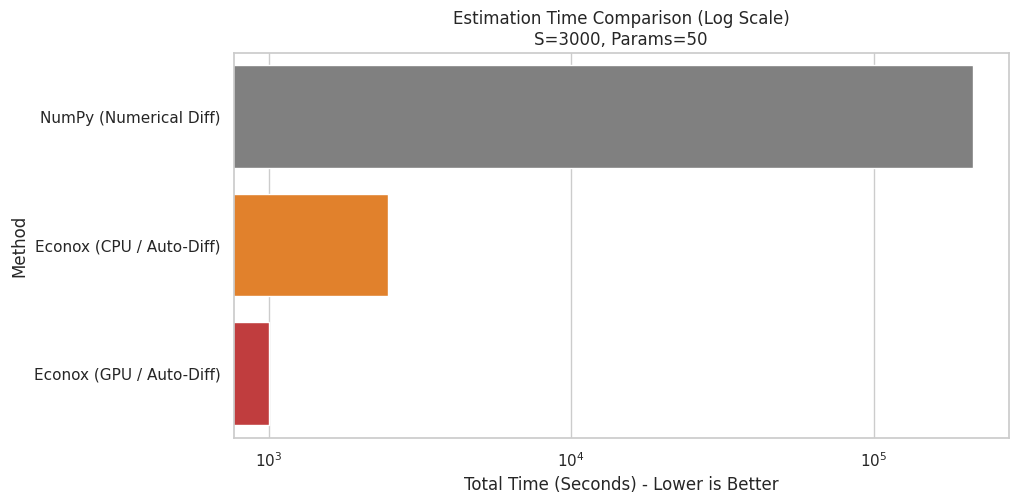

In [23]:
data = {
    "Method": ["NumPy (Numerical Diff)", "Econox (CPU / Auto-Diff)", "Econox (GPU / Auto-Diff)"],
    "Time (Seconds)": [t_numpy, t_total_cpu, t_total_gpu if not np.isnan(t_econox_gpu) else 0],
    "Color": ["gray", "#ff7f0e", "#d62728"]
}
df = pd.DataFrame(data)
if np.isnan(t_econox_gpu): df = df[df["Method"] != "Econox (GPU / Auto-Diff)"]

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Time (Seconds)", y="Method", hue="Method", palette=df["Color"].tolist(), legend=False)
plt.xscale("log")
plt.title(f"Estimation Time Comparison (Log Scale)\nS={S_BENCH}, Params={P_BENCH}")
plt.xlabel("Total Time (Seconds) - Lower is Better")
plt.show()